# Wafer-Die Optimization

The goal of this notebook is to find the optimal number of dies that can be placed on a specific wafer. The user has control over a few different parameters.

### Input parameters: 
- Wafer size (diameter)
- Wafer Edge Exclusion (WEE)
- Dicing Lane Spacing
- Die size (length, width)

### Output Values:
- Die count
- Wafer Utilization
- Optimal X-offset
- Optimal Y-offset
- X & Y Layout (Odd/Even)
- Diagram of Wafer

### Kernel installation
- Use python 3.10.x
- Select "create a Python virtual environment" (Visual Studio Code)
- If you are versed in Conda, then use that, otherwise select **venv**

### Running in Jupyter
- For conda, first use `conda install ipykernel -c conda forge`
- Then use `python -m ipykernel install --user --name=wafer`
- Restart Jupyter Notebook and your kernel should show up

### How to Use this Notebook **IMPORTANT!!!!**
- Run each cell in order
- **ONLY** input parameters in Section 2
- No other code needs to be changed
- Once cell 1 has been run once, there is no need to run it again (ONLY run the imports when restarting kernel)

## 1. Installs and Imports

In [ ]:
pip install shapely matplotlib pandas

In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from collections import defaultdict

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from shapely.geometry import Point, box

## 2. Input Parameters:
Change variables below

For test positions:
1 corner looks like `test_positions = ['xx']` 
2 corners like: `test_position = ['xx', 'yy']` xx and yy are just placeholders, the possible values are written under. Works for as many dies in a scan.

Resolution is for how in-depth the search should be. The lower the number the more it'll check offsets. But be warned that lowering the number will result in longer run-times


In [8]:
# Project Name
project_name = "ruby"

# wafer
wafer_diameter = 200 # mm
wee = 3             # mm

# die
die_w = 10           # mm, die width
die_h = 12           # mm, die height
trench = 0.1         # mm, dicing lane

# scan configuration
dies_per_scan = 4     # number of dies in each scan
scan_cols = 2
scan_rows = 2

assert scan_cols * scan_rows == dies_per_scan, "scan_cols*scan_rows must equal dies_per_scan"

# list of (li, lj) positions within each scan block where you place test dies
# e.g. [(0,0)] for bottom-left, [(0, scan_rows-1)] for top-left, or multiple
test_positions = [(0, scan_rows-1)]


# grid search resolution
res_x = 1
res_y = 1

## 3. Transformed Quantities
Do not change any of the code in any cells from here

In [3]:
# true radii
full_radius   = wafer_diameter / 2.0       # physical wafer edge
usable_radius = full_radius - wee          # inside this all dies must fit
wafer = Point(0,0).buffer(usable_radius)

# effective die size
eff_die_w = die_w + trench
eff_die_h = die_h + trench

# grid spacing
step_x = eff_die_w
step_y = eff_die_h

## 4. Grid Generation and Filtering

In [4]:
def generate_dies(offset_x, offset_y):
    """
    Returns a list of dicts for dies fully inside wafer:
      - x,y      : center coords
      - i,j      : global grid indices
      - orient_x,y: 'even'/'odd' based on i,j
    """
    xs = np.arange(-usable_radius + eff_die_w/2 + offset_x,
                   usable_radius,
                   step_x)
    ys = np.arange(-usable_radius + eff_die_h/2 + offset_y,
                   usable_radius,
                   step_y)
    dies = []
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            rect = box(x - eff_die_w/2, y - eff_die_h/2,
                       x + eff_die_w/2, y + eff_die_h/2)
            if wafer.contains(rect):
                dies.append({
                    'x': x, 'y': y,
                    'i': i, 'j': j,
                    'orient_x': 'odd'  if i % 2 else 'even',
                    'orient_y': 'odd'  if j % 2 else 'even'
                })
    return dies

## 5. Optimized Search

In [5]:
best_count = -1
best_off   = (0.0, 0.0)
best_dies  = None

oxs = np.arange(0, step_x, res_x)
oys = np.arange(0, step_y, res_y)

for ox in oxs:
    for oy in oys:
        current = generate_dies(ox, oy)
        cnt = len(current)
        if cnt > best_count:
            best_count = cnt
            best_off   = (ox, oy)
            best_dies  = current

# freeze the winners
best_x, best_y = best_off
dies           = best_dies
total_positions = best_count

# now print from the SAME list
print(f"Best offsets → X={best_x:.3f} mm, Y={best_y:.3f} mm")
print(f"Total die positions on wafer: {total_positions}")

Best offsets → X=6.000 mm, Y=3.000 mm
Total die positions on wafer: 211


In [6]:
# collect unique grid indices among the final dies
unique_i = sorted({ d['i'] for d in dies })
unique_j = sorted({ d['j'] for d in dies })

num_cols = len(unique_i)
num_rows = len(unique_j)

scan_num_cols = math.ceil(num_cols / scan_cols)
scan_num_rows = math.ceil(num_rows / scan_rows)

orientation_cols = 'even' if scan_num_cols % 2 == 0 else 'odd'
orientation_rows = 'even' if scan_num_rows % 2 == 0 else 'odd'

print(f"Scan Column Orientation: {scan_num_cols} ({orientation_cols})")
print(f"Scan Row Orientation: {scan_num_rows} ({orientation_rows})")

Scan Column Orientation: 9 (odd)
Scan Row Orientation: 8 (even)


## 6. Deliverable Cells

In [9]:
# clear any old flags
for d in dies:
    for key in ('is_test','sx','sy','li','lj'):
        d.pop(key, None)

# compute block & local indices
for d in dies:
    d['sx'] = d['i'] // scan_cols
    d['sy'] = d['j'] // scan_rows
    d['li'] = d['i'] % scan_cols
    d['lj'] = d['j'] % scan_rows

# bucket dies into scan blocks
scans = defaultdict(list)
for d in dies:
    scans[(d['sx'], d['sy'])].append(d)

# tag test-dies by explicit test_positions
test_die_count = 0
for group in scans.values():
    for (li, lj) in test_positions:
        for die in group:
            if die['li']==li and die['lj']==lj:
                if not die.get('is_test', False):
                    die['is_test'] = True
                    test_die_count += 1
                break

# count edge vs inside dies
unique_i = sorted({d['i'] for d in dies})
unique_j = sorted({d['j'] for d in dies})
min_i, max_i = unique_i[0], unique_i[-1]
min_j, max_j = unique_j[0], unique_j[-1]

edge_dies   = sum(1 for d in dies if d['i'] in (min_i,max_i) or d['j'] in (min_j,max_j))
inside_dies = total_positions - edge_dies

print(f"Test dies reserved: {test_die_count}")
print(f"Edge dies: {edge_dies}")
print(f"Inside dies: {inside_dies}")

Test dies reserved: 52
Edge dies: 21
Inside dies: 190


In [10]:
deliverable = total_positions - test_die_count
utilization = deliverable * (eff_die_w * eff_die_h) / (math.pi * usable_radius**2) * 100

# filtered grid-dimensions & parity
num_cols    = len({d['i'] for d in dies})
num_rows    = len({d['j'] for d in dies})
orient_cols = 'even' if num_cols % 2 == 0 else 'odd'
orient_rows = 'even' if num_rows % 2 == 0 else 'odd'

print(f"Total positions:  {total_positions}")
print(f"Deliverable dies: {deliverable}")
print(f"Utilization:      {utilization:.1f}%")

Total positions:  211
Deliverable dies: 159
Utilization:      65.7%


## 7. Plot Final

Saved image to:  ruby_20250709_114313_layout.png
Saved metrics to: ruby_20250709_114313_metrics.txt


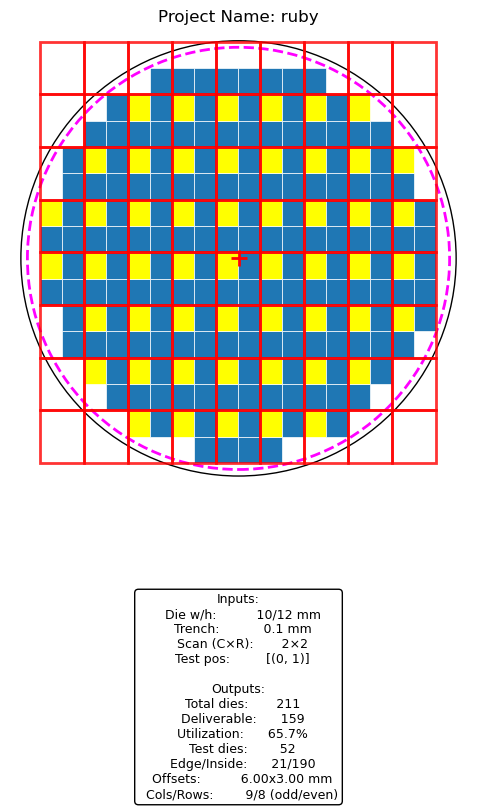

In [11]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from shapely.geometry import box
from datetime import datetime

def unique_filename(base, ext):
    """Generate a unique filename by appending a suffix if needed."""
    i = 0
    while True:
        suffix = f"_{i}" if i > 0 else ""
        fname = f"{base}{suffix}.{ext}"
        if not os.path.exists(fname):
            return fname
        i += 1

# Recompute radii
full_radius   = wafer_diameter / 2.0
usable_radius = full_radius - wee

# Compute origin and pitch for the die-grid
origin_x = -usable_radius + eff_die_w/2 + best_x
origin_y = -usable_radius + eff_die_h/2 + best_y
pitch_x  = step_x
pitch_y  = step_y

# ecompute summary metrics
total_positions = len(dies)
deliverable     = total_positions - test_die_count
utilization     = deliverable * (eff_die_w * eff_die_h) / (math.pi * usable_radius**2) * 100

# Prepare metrics text
metrics_txt = [
    "Inputs:",
    f"  Die w/h:          {die_w}/{die_h} mm",
    f"  Trench:           {trench} mm",
    f"  Scan (C×R):       {scan_cols}×{scan_rows}",
    f"  Test pos:         {test_positions}",
    "",
    "Outputs:",
    f"  Total dies:       {total_positions}",
    f"  Deliverable:      {deliverable}",
    f"  Utilization:      {utilization:.1f}%",
    f"  Test dies:        {test_die_count}",
    f"  Edge/Inside:      {edge_dies}/{inside_dies}",
    f"  Offsets:          {best_x:.2f}x{best_y:.2f} mm",
    f"  Cols/Rows:        {scan_num_cols}/{scan_num_rows} ({orientation_cols}/{orientation_rows})"
]

# Create figure
fig, ax = plt.subplots(figsize=(6, 8), constrained_layout=True)

# Draw wafer and WEE
ax.add_patch(plt.Circle((0,0), full_radius,    fill=False, edgecolor='black', linewidth=1,))
ax.add_patch(plt.Circle((0,0), usable_radius,  fill=False, edgecolor='magenta', linestyle='--', linewidth=2))

# Plot dies & test‐dies
for d in dies:
    rect = box(d['x']-eff_die_w/2, d['y']-eff_die_h/2, d['x']+eff_die_w/2, d['y']+eff_die_h/2)
    xr, yr = rect.exterior.xy
    ax.fill(xr, yr, facecolor=('yellow' if d.get('is_test') else 'C0'), edgecolor='white', linewidth=0.5)

# Draw wafer center cross
ax.plot(0, 0, marker='+', color='red', markersize=12, markeredgewidth=2)

# Draw full‐cell scan boundaries in high‐contrast red
max_sx = max(d['sx'] for d in dies)
max_sy = max(d['sy'] for d in dies)
for sx in range(max_sx + 1):
    for sy in range(max_sy + 1):
        x0c = origin_x + sx * scan_cols * pitch_x
        y0c = origin_y + sy * scan_rows * pitch_y
        x0  = x0c - eff_die_w/2
        y0  = y0c - eff_die_h/2
        w   = scan_cols * pitch_x
        h   = scan_rows * pitch_y
        ax.add_patch(mpatch.Rectangle(
            (x0, y0), w, h,
            fill=False, edgecolor='red', linewidth=2, alpha=0.8
        ))

# Add metrics & inputs box below wafer
ax.text(
    0.5, -0.15,
    "\n".join(metrics_txt),
    transform=ax.transAxes,
    ha='center', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)

# Final formatting
ax.set_aspect('equal')
ax.set_xlim(-full_radius * 1.05, full_radius * 1.05)
ax.set_ylim(-full_radius * 1.2, full_radius * 1.05)
ax.axis('off')
# ax.legend(loc='upper right')
ax.set_title(label=f"Project Name: {project_name}")

# Save image and metrics only
stamp      = datetime.now().strftime("%Y%m%d_%H%M%S")
base       = f"{project_name}_{stamp}"
img_fname  = unique_filename(f"{base}_layout", "png")
txt_fname  = unique_filename(f"{base}_metrics", "txt")

fig.savefig(img_fname, dpi=150, bbox_inches='tight')
with open(txt_fname, 'w') as f:
    f.write("\n".join(metrics_txt))

print(f"Saved image to:  {img_fname}")
print(f"Saved metrics to: {txt_fname}")

plt.show()